In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##Using Convolutions with Complex Images

We previously used the Fashion MNIST dataset to train an image classifier, the images were 28x28 and the subject was centered. We will now create a CNN to recognize images of humans and horses, where the subject is not centered in the image.


In the case of Fashion MNIST, the data was built into TensorFlow via Keras. In this case the data is not, we will do some processing before training.

First, let's download the data:

In [ ]:
!wget \
  https://storage.googleapis.com/learning-datasets/horse-or-human.zip \
  -O /tmp/horse-or-human.zip

--2025-02-26 17:05:29--  https://storage.googleapis.com/learning-datasets/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 172.217.214.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  94.6MB/s    in 1.5s    

2025-02-26 17:05:30 (94.6 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



The following python code will use the OS library to use Operating System libraries, giving us access to the file system, and the zipfile library, to unzip the data.

In [ ]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

We do not label the images as horses or humans (as we did instead with the MNIST dataset earlier).

We will use an *ImageGenerator* to read images from subdirectories, and automatically label them from the name of that subdirectory.
Let's define each of these directories:

In [ ]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

Let's see what the filenames look like in the `horses` and `humans` training directories:

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse35-2.png', 'horse33-8.png', 'horse05-3.png', 'horse05-0.png', 'horse21-9.png', 'horse29-7.png', 'horse48-0.png', 'horse39-0.png', 'horse47-4.png', 'horse25-1.png']
['human13-13.png', 'human09-16.png', 'human08-10.png', 'human15-10.png', 'human17-27.png', 'human01-06.png', 'human14-15.png', 'human05-04.png', 'human09-24.png', 'human10-00.png']


The total number of horse and human images in the directories are:

In [ ]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Display a batch of 8 horse and 8 human pictures. We can rerun the cell to see a fresh batch each time:

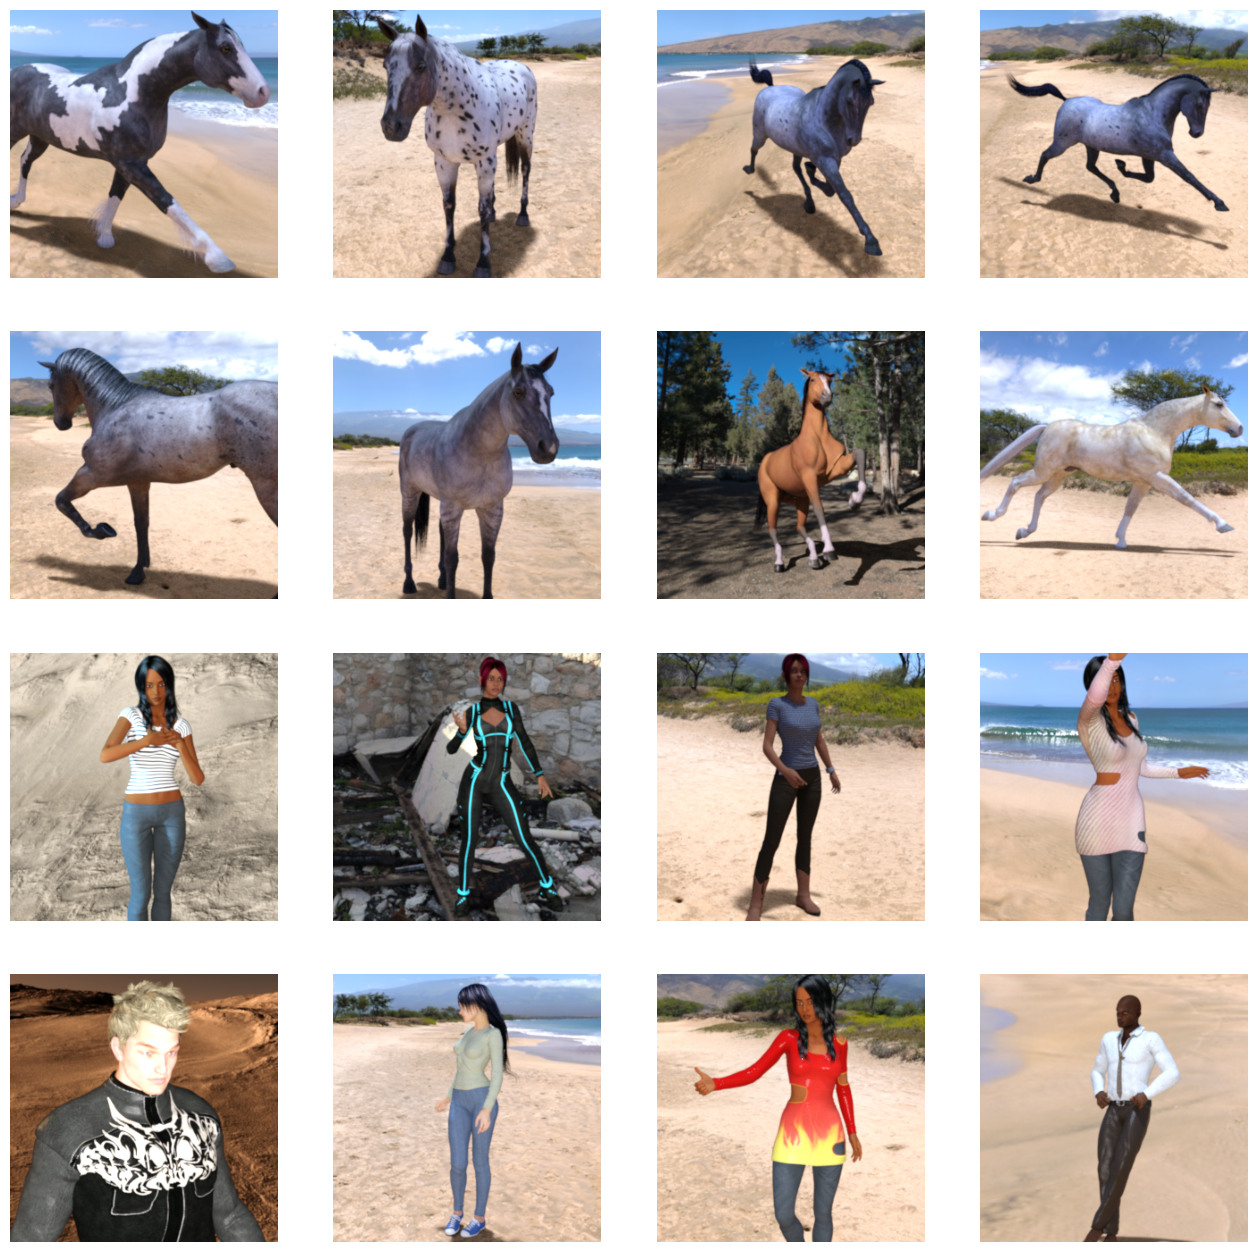

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

Start defining the model:

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers and then add the dense layers.

Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The model.summary() method call prints a summary of the NN

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 78400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      40,141,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,165,409 (153.22 MB)

 Trainable params: 40,165,409 (153.22 MB)

 Non-trainable params: 0 (0.00 B)

The "output shape" column shows how the size of the feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Set up data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

Data that goes into neural networks should usually be normalized, we will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### Training
Train for 15 epochs.
Note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 110s 13s/step - accuracy: 0.5070 - loss: 1.0824
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4219 - loss: 0.8150 
Epoch 3/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.6353 - loss: 0.6874
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7578 - loss: 0.6189 
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 12s/step - accuracy: 0.8501 - loss: 0.5265
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5547 - loss: 0.6081 
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - accuracy: 0.7887 - loss: 0.4713
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7266 - loss: 0.4357 
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 13s/step - accuracy: 0.8468 - loss: 0.3819
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.1493
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 144s 14s/step - accuracy: 0.9223 - loss: 0.2203
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9844 - loss: 0.0537 
Epoch 13/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 12s/step - accuracy: 0.9843 - loss: 0.0515
Epoch 14/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9766 - loss: 0.0698 
Ep

###Running the Model

Run a prediction using the model. We choose 1 or more files from the file system, we can also download images to the file system to try them out.

The network makes a LOT of mistakes, despite the fact that the training accuracy is above 99%.

This is due to something called **overfitting**, which means that the neural network is trained with very limited data -- there are only 500ish images of each class. So it's very good at recognizing images that look like those in the training set, but it can fail a lot at images that are not in the training set.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = x / 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


Saving human-rights-exhibits.jpg to human-rights-exhibits (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
[0.11980046]
human-rights-exhibits (2).jpg is a horse


## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)